<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/09-%20HandsOn%203/QASC/QASC_Learning_Phrase_Repr_RNN_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QASC dataset - RNN Seq2Seq Encoder Decoder solution with Learning Phrase Representation

QASC dataset

question-and-answer data set that focuses on sentence composition. It consists of 9,980 8-channel multiple-choice questions on elementary school science (8,134 train, 926 dev, 920 test)

Files

qasc_dataset folder contains train, test and dev(valid) json files. These files contain question column. Question further contains stem question and 4 answer choices for them. question column has stem and answer choices which contain the answer string. But, the answer string are mostly single word answers for the questions.

Therefore questions will be extracted from question.stem and for corresponding answers combinedfact column will be considered.

File required - train.jsonl, test.jsonl (doesnt contain answers for evaluation, hence ignored) and dev.jsonl

Learnings-

1. The decoder takes the context vector (generated from encoder) along with embedded input token and previous hidden state to predict hidden state (s_t)
2. The context vector is fed to the linear layer along with hidden output to predict the next token.

3. Train, test and val split was done as per the set division provided in the dataset. Train, test, val splits do not share documents. Hence, their information is not leaked. Test loss observed = 5.269 (Perplexity score=194.271).

### Additional packages

In [ ]:
# Packages
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load Dataset

In [ ]:
!wget http://data.allenai.org/downloads/qasc/qasc_dataset.tar.gz

--2021-01-06 06:56:53--  http://data.allenai.org/downloads/qasc/qasc_dataset.tar.gz
Resolving data.allenai.org (data.allenai.org)... 52.218.168.58
Connecting to data.allenai.org (data.allenai.org)|52.218.168.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1616514 (1.5M) [application/x-gzip]
Saving to: ‘qasc_dataset.tar.gz’

qasc_dataset.tar.gz 100%[===================>]   1.54M  --.-KB/s    in 0.1s    

2021-01-06 06:56:54 (15.8 MB/s) - ‘qasc_dataset.tar.gz’ saved [1616514/1616514]



In [ ]:
!tar -xvf qasc_dataset.tar.gz

QASC_Dataset/
QASC_Dataset/train.jsonl
QASC_Dataset/test.jsonl
QASC_Dataset/dev.jsonl


Below are the steps to extract stem and correct choice text column from the json file. Step by step process is done for train set. We'll create a function with these steps to extract for test and valid dataset.

In [ ]:
df_QASC = pd.read_json(path_or_buf='/content/QASC_Dataset/train.jsonl', lines=True)
print(df_QASC.shape)
df_QASC.head()

(8134, 7)


,id,question,answerKey,fact1,fact2,combinedfact,formatted_question
0,3E7TUJ2EGCLQNOV1WEAJ2NN9ROPD9K,{'stem': 'What type of water formation is form...,F,beads of water are formed by water vapor conde...,Clouds are made of water vapor.,Beads of water can be formed by clouds.,What type of water formation is formed by clou...
1,3LS2AMNW5FPNJK3C3PZLZCPX562OQO,"{'stem': 'Where do beads of water come from?',...",E,beads of water are formed by water vapor conde...,Condensation is the change of water vapor to a...,Vapor turning into a liquid leaves behind bead...,Where do beads of water come from? (A) Too muc...
2,3TMFV4NEP8DPIPCI8H9VUFHJG8V8W3,"{'stem': 'What forms beads of water? ', 'choic...",B,beads of water are formed by water vapor conde...,An example of water vapor is steam.,Steam forms beads of water.,What forms beads of water? (A) Necklaces. (B)...
3,3KRVW3HTZNKBWXXDID9D28FTU7NSM9,{'stem': 'what kind of beads are formed from v...,C,beads of water are formed by water vapor conde...,Water is made up of H2O molecules.,h2o beads are formed by h2o vapor condensing,what kind of beads are formed from vapor conde...
4,3TE3O8573079OET7T6QOXPWZ0MHR2T,{'stem': 'what kind of beads are formed by the...,A,beads of water are formed by water vapor conde...,Water is made up of H2O molecules.,beads of h2o are formed by h2o vapor condensing,what kind of beads are formed by their vapor c...


From the given dataframe- question, formatted_question and combinedfact columns have the desired seq2seq strings.

question column has stem and answer choices which contain the answer string. But, the answer string are mostly single word answers for the questions.

Therefore questions will be extracted from question.stem and for corresponding answers combinedfact column will be considered.

In [ ]:
df_QASC[['question', 'formatted_question', 'combinedfact']]

,question,formatted_question,combinedfact
0,{'stem': 'What type of water formation is form...,What type of water formation is formed by clou...,Beads of water can be formed by clouds.
1,"{'stem': 'Where do beads of water come from?',...",Where do beads of water come from? (A) Too muc...,Vapor turning into a liquid leaves behind bead...
2,"{'stem': 'What forms beads of water? ', 'choic...",What forms beads of water? (A) Necklaces. (B)...,Steam forms beads of water.
3,{'stem': 'what kind of beads are formed from v...,what kind of beads are formed from vapor conde...,h2o beads are formed by h2o vapor condensing
4,{'stem': 'what kind of beads are formed by the...,what kind of beads are formed by their vapor c...,beads of h2o are formed by h2o vapor condensing
...,...,...,...
8129,{'stem': 'Chitin can be used for protection by...,Chitin can be used for protection by whom? (A)...,Chitin can be used for protection by fish.
8130,{'stem': 'Which type of animal uses plates for...,Which type of animal uses plates for protectio...,Reptiles use their plates for protection.
8131,{'stem': 'What are used for protection by fish...,What are used for protection by fish? (A) scal...,scales are used for protection by fish
8132,"{'stem': 'What are pangolins covered in?', 'ch...",What are pangolins covered in? (A) tunicates (...,Pangolins are covered in overlapping protection.


Extract stem and choices from question columns by pd.normalize

In [ ]:
df_QASC = df_QASC.join(pd.json_normalize(df_QASC.question))
print(df_QASC.shape)
df_QASC.head()

(8134, 9)


,id,question,answerKey,fact1,fact2,combinedfact,formatted_question,stem,choices
0,3E7TUJ2EGCLQNOV1WEAJ2NN9ROPD9K,{'stem': 'What type of water formation is form...,F,beads of water are formed by water vapor conde...,Clouds are made of water vapor.,Beads of water can be formed by clouds.,What type of water formation is formed by clou...,What type of water formation is formed by clouds?,"[{'text': 'pearls', 'label': 'A'}, {'text': 's..."
1,3LS2AMNW5FPNJK3C3PZLZCPX562OQO,"{'stem': 'Where do beads of water come from?',...",E,beads of water are formed by water vapor conde...,Condensation is the change of water vapor to a...,Vapor turning into a liquid leaves behind bead...,Where do beads of water come from? (A) Too muc...,Where do beads of water come from?,"[{'text': 'Too much water', 'label': 'A'}, {'t..."
2,3TMFV4NEP8DPIPCI8H9VUFHJG8V8W3,"{'stem': 'What forms beads of water? ', 'choic...",B,beads of water are formed by water vapor conde...,An example of water vapor is steam.,Steam forms beads of water.,What forms beads of water? (A) Necklaces. (B)...,What forms beads of water?,"[{'text': 'Necklaces.', 'label': 'A'}, {'text'..."
3,3KRVW3HTZNKBWXXDID9D28FTU7NSM9,{'stem': 'what kind of beads are formed from v...,C,beads of water are formed by water vapor conde...,Water is made up of H2O molecules.,h2o beads are formed by h2o vapor condensing,what kind of beads are formed from vapor conde...,what kind of beads are formed from vapor conde...,"[{'text': 'tiny', 'label': 'A'}, {'text': 'H20..."
4,3TE3O8573079OET7T6QOXPWZ0MHR2T,{'stem': 'what kind of beads are formed by the...,A,beads of water are formed by water vapor conde...,Water is made up of H2O molecules.,beads of h2o are formed by h2o vapor condensing,what kind of beads are formed by their vapor c...,what kind of beads are formed by their vapor c...,"[{'text': 'h2o', 'label': 'A'}, {'text': 'rain..."


Create train dataframe with stem and text columns renamed as question and answer as column names

In [ ]:
df_train_qa = df_QASC[['stem', 'combinedfact']].rename(columns={'stem': 'question', 'combinedfact': 'answer1'})
print(df_train_qa.shape)
df_train_qa.head()

(8134, 2)


,question,answer1
0,What type of water formation is formed by clouds?,Beads of water can be formed by clouds.
1,Where do beads of water come from?,Vapor turning into a liquid leaves behind bead...
2,What forms beads of water?,Steam forms beads of water.
3,what kind of beads are formed from vapor conde...,h2o beads are formed by h2o vapor condensing
4,what kind of beads are formed by their vapor c...,beads of h2o are formed by h2o vapor condensing


#### Function create required dataframe for val and test.

In [ ]:
def json_to_df(filename):
    df_QASC = pd.read_json(path_or_buf=filename, lines=True)
    df_QASC = df_QASC.join(pd.json_normalize(df_QASC.question))
    return df_QASC[['stem', 'combinedfact']].rename(columns={'stem': 'question', 'combinedfact': 'answer1'})

Dataframe for valid

In [ ]:
df_valid_qa = json_to_df('/content/QASC_Dataset/dev.jsonl')
print(df_valid_qa.shape)
df_valid_qa.head()

(926, 2)


,question,answer1
0,Climate is generally described in terms of what?,Climate is generally described in terms of loc...
1,what varies by altitude?,temperature and moisture varies by alltitude
2,What is changing globally?,temperature and moisture is changing globally
3,what are generally described in terms of tempe...,average weather conditions are generally descr...
4,What is described in terms of temperature and ...,Climate is usually described in terms of tempe...


Data frame for test

test.jsonl file doesnt contain answers. So evaluation on test cannot be done.

### Download and load spacy models

This is going to be used for tokenization.

In [ ]:
# Download and load spacy models for EN language. To be used for tokenization.
%%bash
python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
spacy_en = spacy.load('en')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
tokenize_en("Spacy model for EN is loaded up.")

['Spacy', 'model', 'for', 'EN', 'is', 'loaded', 'up', '.']

### Prepare FIELDS

Defines a datatype together with instructions for converting to Tensor. holds a Vocab object that defines the set of possible values
    for elements of the field and their corresponding numerical representations.

QUESTIONS - Field containing the questions for training.
ANSWERS - Field for prediction.

In [ ]:
QUESTIONS = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)
ANSWERS = Field(tokenize = tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

In [ ]:
print(type(QUESTIONS))
QUESTIONS.__dict__

<class 'torchtext.data.field.Field'>


{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True}

Create a list of (name, field) pairs as the fields argument. The fields we pass in must be in the same order as the columns

In [ ]:
fields = [('question', QUESTIONS), ('answer1', ANSWERS)]

Convert from pandas to list to torchtext.

In [ ]:
example_train = [data.Example.fromlist([df_train_qa.question[i],df_train_qa.answer1[i]], fields) for i in range(df_train_qa.shape[0])] 
example_valid = [data.Example.fromlist([df_valid_qa.question[i],df_valid_qa.answer1[i]], fields) for i in range(df_valid_qa.shape[0])] 
# example_test = [data.Example.fromlist([df_test_qa.question[i],df_test_qa.answer1[i]], fields) for i in range(df_test_qa.shape[0])] 

In [ ]:
# Creating dataset
train_data = data.Dataset(example_train, fields)
valid_data = data.Dataset(example_valid, fields)
# test_data = data.Dataset(example_test, fields)

In [ ]:
print(vars(train_data.examples[0]))

{'question': ['what', 'type', 'of', 'water', 'formation', 'is', 'formed', 'by', 'clouds', '?'], 'answer1': ['beads', 'of', 'water', 'can', 'be', 'formed', 'by', 'clouds', '.']}


In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
# print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 8134
Number of validation examples: 926


### Build vocabulary for SRC and TRG

Vocabulary will associate each unique tokens with an index. Only tokens that appear atleast 2 times are considered. Other such words are replaced by < UNK >. Vocab object built on only training examples.

In [ ]:
QUESTIONS.build_vocab(train_data, min_freq = 2)
ANSWERS.build_vocab(train_data, min_freq = 2)

In [ ]:
print("Size of Source vocab: ",len(QUESTIONS.vocab))
print("Size of Target vocab: ",len(ANSWERS.vocab))

Size of Source vocab:  2498
Size of Target vocab:  3028


In [ ]:
vars(QUESTIONS)

{'batch_first': False,
 'dtype': torch.int64,
 'eos_token': '<eos>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<sos>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True,
 'vocab': <torchtext.vocab.Vocab at 0x7f5ea6a54c18>}

In [ ]:
# QUESTIONS.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(QUESTIONS.vocab.__dict__.keys())
QUESTIONS.vocab.__dict__

dict_keys(['freqs', 'itos', 'stoi', 'vectors'])


{'freqs': Counter({'what': 6953,
          'type': 100,
          'of': 1819,
          'water': 422,
          'formation': 10,
          'is': 1355,
          'formed': 172,
          'by': 623,
          'clouds': 17,
          '?': 7211,
          'where': 247,
          'do': 1047,
          'beads': 7,
          'come': 26,
          'from': 457,
          'forms': 44,
          'kind': 88,
          'are': 883,
          'vapor': 47,
          'condensing': 17,
          'their': 184,
          'happens': 131,
          'to': 2185,
          'the': 2199,
          'heat': 223,
          'energy': 368,
          'during': 67,
          'condensation': 6,
          '.': 109,
          'doing': 34,
          'liquid': 72,
          'when': 511,
          'likely': 28,
          'form': 144,
          'removing': 5,
          'food': 264,
          'will': 113,
          'preserve': 4,
          'it': 220,
          'two': 49,
          'ways': 8,
          'you': 65,
          'can

### Create iterators for train, valid and test.

BucketIterator is used instead of Standard Iterator. BucketIterator defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch.

batch.QUESTIONS - [ (128) , (128), .. 23 times]**bold text**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# TypeError: '<' not supported between instances of 'Example' and 'Example'
# This happens because the dataset iterator from torchtext tries to sort the dataset, which implies comparing two elements. 
# have to provide a sorting function to the constructor of the BucketIterator
BATCH_SIZE = 128

train_iterator, valid_iterator  = BucketIterator.splits(
    (train_data, valid_data), 
    sort=False,
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
batch = next(iter(train_iterator))
print(batch)


[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 22x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 22x128 (GPU 0)]


In [ ]:
# Batch contains question and answer1. Can be accessed as batch.question (tensor) and batch.answer1 (tensor)
# batch.question groups the first element of all sequences in batch of 128, then groups second element of sequence in batch 128.
print(type(batch))
print(batch)
print('Data type of batch.question', type(batch.question))
print("Length of a source sequence", len(batch.question))
print("Length of source at first index. (2 is for <sos>)", len(batch.question[0]))
print("Length of source at last index. (6 - what , 8- does )", len(batch.question[-1]))
print("Values at source first index", batch.question[0])
print(batch.answer1[1])

<class 'torchtext.data.batch.Batch'>

[torchtext.data.batch.Batch of size 128]
	[.question]:[torch.cuda.LongTensor of size 22x128 (GPU 0)]
	[.answer1]:[torch.cuda.LongTensor of size 22x128 (GPU 0)]
Data type of batch.question <class 'torch.Tensor'>
Length of a source sequence 22
Length of source at first index. (2 is for <sos>) 128
Length of source at last index. (6 - what , 8- does ) 128
Values at source first index tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor([  17,   52,  505,    6,   17, 1419,    6,  796,  228,    0,  110,  173,
           0,  679,  905,  534,  642,  375,  156,

### Building the Seq2Seq Model
<a name="model"></a>
Using single layered GRU network.

#### Encoder

GRU is that it only requires and returns a hidden state, there is no cell state like in the LSTM.

it takes in a sequence, $X = \{x_1, x_2, ... , x_T\}$, passes it through the embedding layer, recurrently calculates hidden states, $H = \{h_1, h_2, ..., h_T\}$, and returns a context vector (the final hidden state), $z=h_T$.

$$h_t = \text{EncoderGRU}(e(x_t), h_{t-1})$$

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        
        #no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]        
        outputs, hidden = self.rnn(embedded) #no cell state!
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden

#### Decoder

Two changes:
1. Instead of the GRU in the decoder taking just the embedded target token, $d(y_t)$ and the previous hidden state $s_{t-1}$ as inputs, it also takes the context vector $z$. 

$$s_t = \text{DecoderGRU}(d(y_t), s_{t-1}, z)$$


The context vector z does not have a subscript. This means we re-use the same context vector returned by the encoder for every decoder time step.

2. Previously, the next token was predicted with linear layer applied on the hidden state output on the top layer.

$$\hat{y}_{t+1}=f(s_t^L)$$

Now, we also pass the embedding of current token, $d(y_t)$ and the context vector, $z$ to the linear layer.

$$\hat{y}_{t+1} = f(d(y_t), s_t, z)$$

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq6.png?raw=1)

hypothetically the decoder hidden states,  st , no longer need to contain information about the source sequence as it is always available as an input. Thus, it only needs to contain information about what tokens it has generated so far. The addition of  yt  to the linear layer also means this layer can directly see what the token is, without having to get this information from the hidden state.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)

        self.fc_out = nn.Linear(emb_dim + 2 * hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #context = [n layers * n directions, batch size, hid dim]
        
        #n layers and n directions in the decoder will both always be 1, therefore:
        #hidden = [1, batch size, hid dim]
        #context = [1, batch size, hid dim]
        
        input = input.unsqueeze(0)
        # input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb_dim]

        emb_con = torch.cat((embedded, context), dim=2)
        # emb_con = [1, batch size, emb_dim + hid_dim]

        output, hidden = self.rnn(emb_con, hidden)
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #seq len, n layers and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [1, batch size, hid dim]

        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1)
        # output = [batch size, emb dim + 2 * hid dim]

        prediction = self.fc_out(output)
        # prediction = [batch_size, output_dim]

        return prediction, hidden 

#### Seq2Seq model

Putting the encoder and decoder together, we get:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Again, in this implementation we need to ensure the hidden dimensions in both the encoder and the decoder are the same.

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive a `context` vector
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and the context vector, $z$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate (either the ground truth next token in the target sequence or the highest predicted next token)

In [ ]:
# build seq2seq model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # tensor to store decoder output
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Last hidden state of the encoder is the context
        context = self.encoder(src)

        # context is also used as the initial hidden state of the decoder
        hidden = context

        # fist input to the decoder is <sos> token
        input = trg[0,:]

        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            # decide of teacher forcing is going to be used
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

### Training the Seq2Seq Model

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [ ]:
INPUT_DIM = len(QUESTIONS.vocab)
OUTPUT_DIM = len(ANSWERS.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

#### Initialize model parameters
Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2498, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3028, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=3028, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,445,396 trainable parameters


#### Initialize optimizer and loss function.

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = ANSWERS.vocab.stoi[ANSWERS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

#### TRAIN loop

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        question = batch.question
        answer = batch.answer1
        
        optimizer.zero_grad()
        
        output = model(question, answer)
        
        #answer = [answer len, batch size]
        #output = [answer len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        answer = answer[1:].view(-1)
        
        #answer = [(answer len - 1) * batch size]
        #output = [(answer len - 1) * batch size, output dim]
        
        loss = criterion(output, answer)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### Eval loop

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            question = batch.question
            answer = batch.answer1
            print

            output = model(question, answer, 0) #turn off teacher forcing

            #answer = [answer len, batch size]
            #output = [answer len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            answer = answer[1:].view(-1)

            #answer = [(answer len - 1) * batch size]
            #output = [(answer len - 1) * batch size, output dim]

            loss = criterion(output, answer)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model train

In [ ]:
train_loss_all = []
val_loss_all = []

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_loss_all.append(train_loss)
    val_loss_all.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 4s
	Train Loss: 6.239 | Train PPL: 512.556
	 Val. Loss: 5.347 |  Val. PPL: 209.951
Epoch: 02 | Time: 0m 4s
	Train Loss: 5.633 | Train PPL: 279.385
	 Val. Loss: 5.285 |  Val. PPL: 197.395
Epoch: 03 | Time: 0m 4s
	Train Loss: 5.399 | Train PPL: 221.135
	 Val. Loss: 5.344 |  Val. PPL: 209.293
Epoch: 04 | Time: 0m 4s
	Train Loss: 5.176 | Train PPL: 177.036
	 Val. Loss: 5.414 |  Val. PPL: 224.577
Epoch: 05 | Time: 0m 4s
	Train Loss: 4.988 | Train PPL: 146.595
	 Val. Loss: 5.405 |  Val. PPL: 222.553
Epoch: 06 | Time: 0m 4s
	Train Loss: 4.825 | Train PPL: 124.591
	 Val. Loss: 5.313 |  Val. PPL: 202.931
Epoch: 07 | Time: 0m 4s
	Train Loss: 4.650 | Train PPL: 104.540
	 Val. Loss: 5.315 |  Val. PPL: 203.426
Epoch: 08 | Time: 0m 4s
	Train Loss: 4.475 | Train PPL:  87.815
	 Val. Loss: 5.275 |  Val. PPL: 195.356
Epoch: 09 | Time: 0m 4s
	Train Loss: 4.275 | Train PPL:  71.873
	 Val. Loss: 5.269 |  Val. PPL: 194.271
Epoch: 10 | Time: 0m 4s
	Train Loss: 4.059 | Train PPL:  57.925


In [ ]:
# model.load_state_dict(torch.load('tut2-model.pt'))

# test_loss = evaluate(model, test_iterator, criterion)

# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Train, val loss curve

In [ ]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, val_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(val_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch curve")

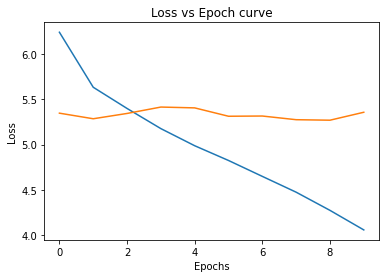

In [ ]:
train_test_metrics_graph(train_loss_all, val_loss_all)